<a href="https://colab.research.google.com/github/dattali18/IR_Assignments/blob/main/Assignment.02/notebooks/IR_02_Clustering_TFIDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering

## 1. Objective

Take the document (meaning vector representation of the document, the ouput of the last assginment `Doc2Vec`, `BERT`, `Sentence-BERT`, times 4 group from each) and cluster them into groups and compare the results with the actuale division form each publication.

## 2. Input

4 Groups of matrices each line repesent a document in it's vector form, from:

1. `Doc2Vec`
2. `BERT`
3. `Sentence-BERT`

### 3. Task

  - Combine the four matrices into a single matrix for each technique.
  - Apply clustering using:
    - **K-Means** (with `k=4` for 4 journals).
    - **DBSCAN** (select `eps` and `min_samples` heuristically).
    - **Gaussian Mixture Model**.
  - Evaluate the clusters using:
    - Metrics: Precision, Recall, F1-Score, Accuracy.
    - Visualization: Use UMAP, t-SNE, or other tools (e.g., Seaborn).


### 4. Output

- The plot of the real clusters vs. the clusters from the 3 methods mentioned above.
- The metrics for each clustering method.

# Doc2Vec Matrices

We have 4 `.csv` files with each $(100, \approx 600)$ and we need to combine them into one big matrix and then cluster them.

## Plan

1. Download the files from my `GitHub`.
2. Add a `'cluster'` column for each file (`=0` for AJ etc...).
3. Cluster with `Kmeans` for `k=4`.
4. Write a function to find the right parameters for 4 clusters for `DBSCAN` (i.e. the `eps` and `min_samples` parameters).
5. Cluster with `DBSCAN`
6. Cluster with `GMM`
7. Use `t-SNE` to visualize the cluster in $\mathbb{R}^2$
8. Output the plot for each clustering methods + original
9. Measure each method using the metric mentioned above.

In [1]:
import warnings

warnings.filterwarnings("ignore")

Download the files from my `GitHub`

In [11]:
# aj_clean_link = "https://github.com/dattali18/IR_Assignments/tree/main/Assignment.02/data/TF-IDF/bm25_clean_A-J.xlsx?raw=true"
# bbc_clean_link = "https://github.com/dattali18/IR_Assignments/tree/main/Assignment.02/data/TF-IDF/bm25_clean_BBC.xlsx?raw=true"
# nyt_clean_link = "https://github.com/dattali18/IR_Assignments/tree/main/Assignment.02/data/TF-IDF/bm25_clean_NY-T.xlsx?raw=true"
# jp_clean_link = "https://github.com/dattali18/IR_Assignments/tree/main/Assignment.02/data/TF-IDF/bm25_clean_J-P.xlsx?raw=true"

In [13]:
# !rm -rf data/

In [12]:
# # download the file into the data dir and then try opening them
# import requests
# import os

# # if data dir doesnt exists create it
# if not os.path.exists("data"):
#     os.makedirs("data")

# def download_file(url, filename):
#     response = requests.get(url)
#     with open(filename, 'wb') as f:
#         f.write(response.content)
#     print("Downloaded file into data dir")

# download_file(aj_clean_link, "data/aj_clean.xlsx")
# download_file(bbc_clean_link, "data/bbc_clean.xlsx")
# download_file(nyt_clean_link, "data/nyt_clean.xlsx")
# download_file(jp_clean_link, "data/jp_clean.xlsx")

Downloaded file into data dir
Downloaded file into data dir
Downloaded file into data dir
Downloaded file into data dir


In [2]:
import pandas as pd

df_aj = pd.read_excel("data/bm25_clean_A-J.xlsx")
# df_bbc = pd.read_excel("data/bm25_clean_BBC.xlsx")
# df_nyt = pd.read_excel("data/bm25_clean_NY-T.xlsx")
# df_jp = pd.read_excel("data/bm25_clean_J-P.xlsx")

df_aj.head()

,DocumentIndex,israel,said,gaza,israeli,hamas,rsquo,ldquo,rdquo,war,...,inconsistencies,kindertransport,longest-serving,indiscriminately,american-supplied,behind-the-scenes,counterproductive,counterprotesters,interdisciplinary,counter-protesters
0,0,0.00000,0.0,1.893326,0.373610,0.0,0,0,0,0.0000,...,0,0,0,0,0,0.0,0,0,0,0.0
1,1,0.18534,0.0,0.000000,0.377472,0.0,0,0,0,0.0000,...,0,0,0,0,0,0.0,0,0,0,0.0
2,2,0.00000,0.0,1.950967,0.648199,0.0,0,0,0,0.0000,...,0,0,0,0,0,0.0,0,0,0,0.0
3,3,0.00000,0.0,1.338546,0.000000,0.0,0,0,0,0.0557,...,0,0,0,0,0,0.0,0,0,0,0.0
4,4,0.00000,0.0,2.077459,0.591964,0.0,0,0,0,0.0000,...,0,0,0,0,0,0.0,0,0,0,0.0


In [3]:
df_bbc = pd.read_excel("data/bm25_clean_BBC.xlsx")
df_nyt = pd.read_excel("data/bm25_clean_NY-T.xlsx")
df_jp = pd.read_excel("data/bm25_clean_J-P.xlsx")

print(df_bbc.shape)
print(df_nyt.shape)
print(df_jp.shape)

(549, 7975)
(599, 7975)
(599, 7975)


In [4]:
# create a new df where we concat all the 4 other df but before we add a 'sheet'
# col with aj for aj etc
# remove the DocumentIndex col
# and instead add an id of aj_<index> bbc_<index>

# create an id col
df_aj['id'] = 'aj_' + df_aj['DocumentIndex'].astype(str)
df_bbc['id'] = 'bbc_' + df_bbc['DocumentIndex'].astype(str)
df_nyt['id'] = 'nyt_' + df_nyt['DocumentIndex'].astype(str)
df_jp['id'] = 'jp_' + df_jp['DocumentIndex'].astype(str)

# remove the DocumentIndex col
df_aj = df_aj.drop(columns=['DocumentIndex'])
df_bbc = df_bbc.drop(columns=['DocumentIndex'])
df_nyt = df_nyt.drop(columns=['DocumentIndex'])
df_jp = df_jp.drop(columns=['DocumentIndex'])

# add an sheet col
df_aj['Sheet'] = 'A-J'
df_bbc['Sheet'] = 'BBC'
df_nyt['Sheet'] = 'NY-T'
df_jp['Sheet'] = 'J-P'

# concat all the 4 df
df = pd.concat([df_aj, df_bbc, df_nyt, df_jp])

df.shape

(2346, 7976)

In [5]:
df.head()

,israel,said,gaza,israeli,hamas,rsquo,ldquo,rdquo,war,us,...,longest-serving,indiscriminately,american-supplied,behind-the-scenes,counterproductive,counterprotesters,interdisciplinary,counter-protesters,id,Sheet
0,0.00000,0.0,1.893326,0.373610,0.0,0.0,0.0,0.0,0.0000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,aj_0,A-J
1,0.18534,0.0,0.000000,0.377472,0.0,0.0,0.0,0.0,0.0000,1.226182,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,aj_1,A-J
2,0.00000,0.0,1.950967,0.648199,0.0,0.0,0.0,0.0,0.0000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,aj_2,A-J
3,0.00000,0.0,1.338546,0.000000,0.0,0.0,0.0,0.0,0.0557,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,aj_3,A-J
4,0.00000,0.0,2.077459,0.591964,0.0,0.0,0.0,0.0,0.0000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,aj_4,A-J


In [6]:
# reorder the col to have id and Sheet col to the start
df = df[['id', 'Sheet'] + [col for col in df.columns if col not in ['id', 'Sheet']]]

df.head()

,id,Sheet,israel,said,gaza,israeli,hamas,rsquo,ldquo,rdquo,...,inconsistencies,kindertransport,longest-serving,indiscriminately,american-supplied,behind-the-scenes,counterproductive,counterprotesters,interdisciplinary,counter-protesters
0,aj_0,A-J,0.00000,0.0,1.893326,0.373610,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,aj_1,A-J,0.18534,0.0,0.000000,0.377472,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,aj_2,A-J,0.00000,0.0,1.950967,0.648199,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,aj_3,A-J,0.00000,0.0,1.338546,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,aj_4,A-J,0.00000,0.0,2.077459,0.591964,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# create the vector col
df['vector'] = df.iloc[:, 2:].values.tolist()

df.head()

,id,Sheet,israel,said,gaza,israeli,hamas,rsquo,ldquo,rdquo,...,kindertransport,longest-serving,indiscriminately,american-supplied,behind-the-scenes,counterproductive,counterprotesters,interdisciplinary,counter-protesters,vector
0,aj_0,A-J,0.00000,0.0,1.893326,0.373610,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 1.893326376881906, 0.37361009867568..."
1,aj_1,A-J,0.18534,0.0,0.000000,0.377472,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.1853396197512515, 0.0, 0.0, 0.3774716369817..."
2,aj_2,A-J,0.00000,0.0,1.950967,0.648199,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 1.950966635001597, 0.64819920982025..."
3,aj_3,A-J,0.00000,0.0,1.338546,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 1.338545880678982, 0.0, 0.0, 0.0, 0..."
4,aj_4,A-J,0.00000,0.0,2.077459,0.591964,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 2.07745855842562, 0.591964341640264..."


In [8]:
# standerdize the data mean=0 std=1

from sklearn.preprocessing import StandardScaler
import numpy as np


scaler = StandardScaler()

# apply to each line of the df

df['std_vector'] = df['vector'].apply(lambda x: scaler.fit_transform(np.array(x).reshape(-1, 1)).flatten())
df['std_vector'].head()

,std_vector
0,"[-0.054619953467782575, -0.054619953467782575,..."
1,"[0.7424595017498579, -0.05817892126005486, -0...."
2,"[-0.05898953471048584, -0.05898953471048584, 8..."
3,"[-0.055352259781569685, -0.055352259781569685,..."
4,"[-0.053095707056546, -0.053095707056546, 8.296..."


In [9]:
cluster_map = {'A-J': 0, 'BBC': 1, 'J-P': 2, 'NY-T': 3}
df['cluster'] = df['Sheet'].map(cluster_map)

In [16]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

In [17]:
# visualize the real cluster using t-SNE

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)

# transofrm the df['vector'] to dataframe with freatuer 0 - 299 for
df_copy = df['std_vector'].apply(pd.Series)

df_tsne = tsne.fit_transform(df_copy)

df_tsne = pd.DataFrame(df_tsne, columns=['x', 'y'])

In [32]:
df_tsne['cluster'] = df['cluster'].astype(str).values

In [33]:
# print the col name of df_tsne
df_tsne.head()

,x,y,cluster
0,-27.501118,-19.840776,0
1,0.310439,23.311745,0
2,3.521003,3.698400,0
3,-51.727081,-8.922517,0
4,6.055501,-19.095232,0


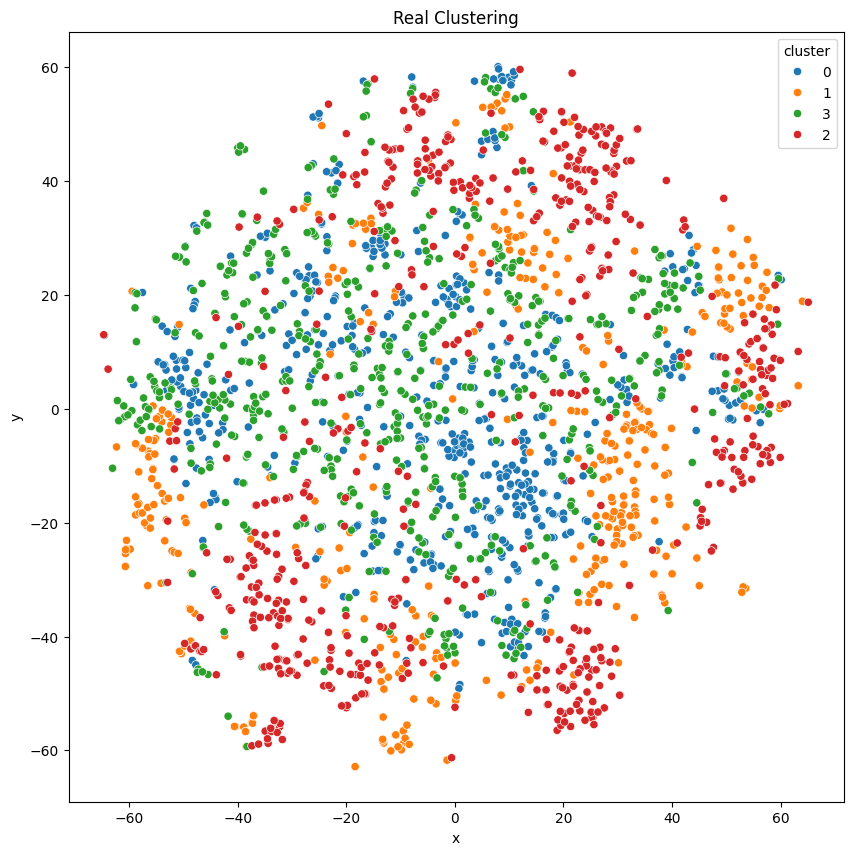

In [36]:
import matplotlib.pyplot as plt

import seaborn as sns

# plot the df_tsne
plt.figure(figsize=(10, 10))
# add labels
plt.title('Real Clustering')

# make color scheme red, blue, green etc
sns.scatterplot(data=df_tsne, x='x', y='y', hue='cluster')

# create a scatterplot

# plt.scatter(df_tsne['x'], df_tsne['y'], c=df_tsne['cluster'])

# show the plot

plt.show()

### Kmeans

In [37]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(df['std_vector'].tolist())

df['cluster_kmeans'] = kmeans.labels_

df['cluster_kmeans'].head()

,cluster_kmeans
0,1
1,0
2,1
3,3
4,1


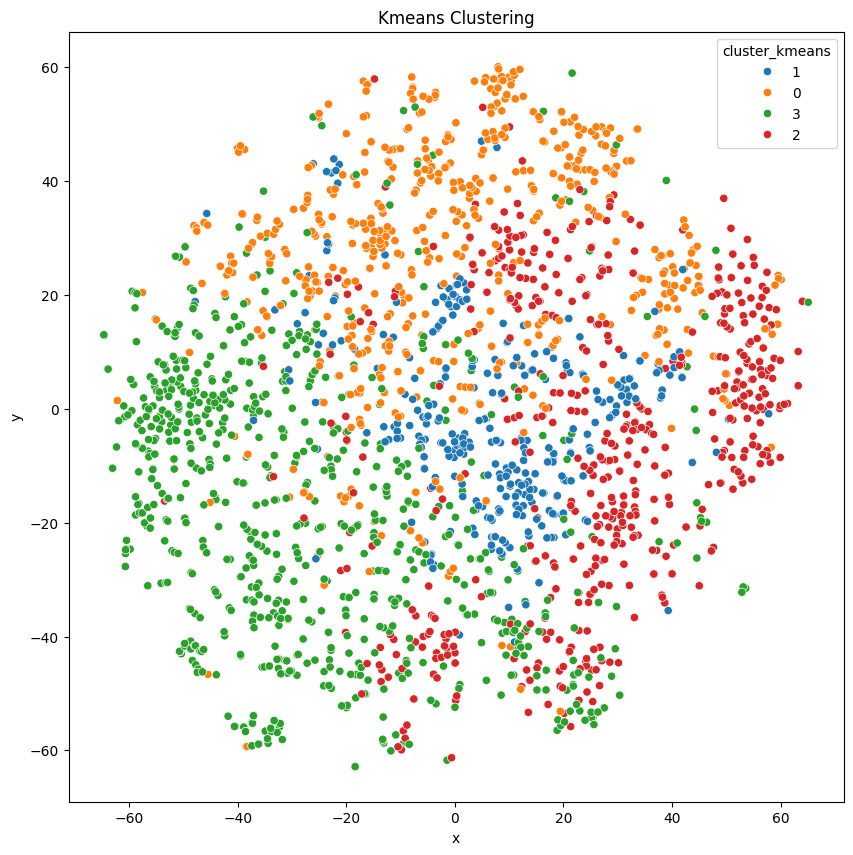

In [38]:
# visutalize the cluster using the t-SNE df

df_tsne['cluster_kmeans'] = df['cluster_kmeans'].astype(str).values

reverse_cluster_map = {v: k for k, v in cluster_map.items()}

plt.figure(figsize=(10, 10))

plt.title('Kmeans Clustering')

# make color scheme red, blue, green etc


df_tsne['cluster_kmeans'] = df_tsne['cluster_kmeans'].map(str)

sns.scatterplot(data=df_tsne, x='x', y='y', hue='cluster_kmeans')

plt.show()

### DBSCAN

In [39]:
!pip install kneed

In [50]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from sklearn.cluster import DBSCAN

def get_parameters(df, num_clusters=4, eps_adjustment=1.0, min_samples_adjustment=1):
    X = np.array(df)

    # Ensure n_neighbors does not exceed the number of samples
    n_neighbors = min(2 * X.shape[1] - 1, len(X) - 1)
    neighbors = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
    neighbors_fit = neighbors.fit(X)
    distances, indices = neighbors_fit.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:, 1]

    # Use KneeLocator to find the "elbow" point in the k-distance graph
    kneedle = KneeLocator(range(len(distances)), distances, S=1.0, curve="convex", direction="increasing")
    eps = distances[kneedle.elbow] * eps_adjustment

    # Set min_samples to 2 * dimensions, another common heuristic
    min_samples = 2 * X.shape[1] * min_samples_adjustment

    return eps, min_samples

def find_best_parameters(df, num_clusters=4):
    best_eps = None
    best_min_samples = None
    best_num_clusters = 0

    for eps_adjustment in np.arange(0.5, 2.0, 0.1):
        for min_samples_adjustment in range(1, 5):
            eps, min_samples = get_parameters(df, num_clusters, eps_adjustment, min_samples_adjustment)
            # Use DBSCAN with cosine similarity
            db = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine').fit(df)
            labels = db.labels_
            num_clusters_found = len(set(labels)) - (1 if -1 in labels else 0)

            if num_clusters_found == num_clusters:
                return eps, min_samples

            if num_clusters_found > best_num_clusters:
                best_eps = eps
                best_min_samples = min_samples
                best_num_clusters = num_clusters_found

    return best_eps, best_min_samples

vector_data = np.array(df['std_vector'].tolist())  # Convert column to 2D numpy array

eps, min_samples = get_parameters(vector_data, num_clusters=4)
print(f"Best eps: {eps}, Best min_samples: {min_samples}")

Best eps: 0.9022547382747841, Best min_samples: 15948


In [51]:
# use DBSCAN

dbscan = DBSCAN(eps=eps, min_samples=15948).fit(df['std_vector'].tolist())

df['cluster_dbscan'] = dbscan.labels_

In [52]:
# count the number of cluster

num_clusters = len(df['cluster_dbscan'].unique())

print(f"Number of clusters: {num_clusters}")

Number of clusters: 1


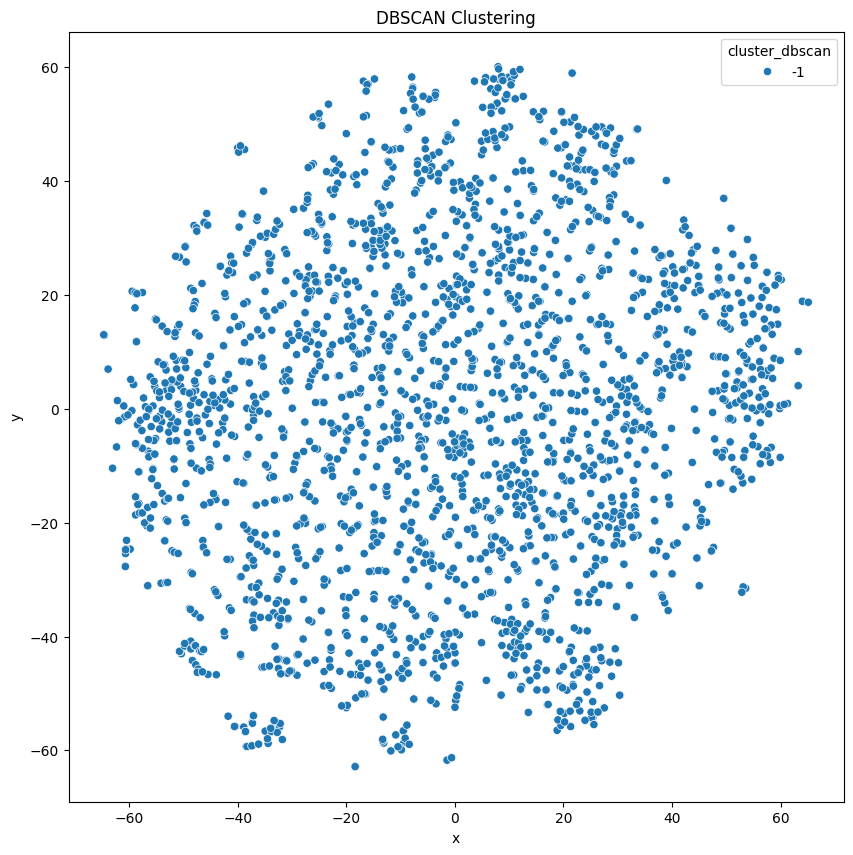

In [53]:
# visualize data

# visutalize the cluster using the t-SNE df

df_tsne['cluster_dbscan'] = df['cluster_dbscan'].astype(str).values

reverse_cluster_map = {v: k for k, v in cluster_map.items()}

plt.figure(figsize=(10, 10))

plt.title('DBSCAN Clustering')

# make color scheme red, blue, green etc


df_tsne['cluster_dbscan'] = df_tsne['cluster_dbscan'].map(str)

sns.scatterplot(data=df_tsne, x='x', y='y', hue='cluster_dbscan')

plt.show()

### GMM

In [54]:
# apply GMM

gmm = GaussianMixture(n_components=4, random_state=0).fit(df['std_vector'].tolist())

df['cluster_gmm'] = gmm.predict(df['std_vector'].tolist())

df['cluster_gmm'].head()


,cluster_gmm
0,1
1,0
2,1
3,3
4,1


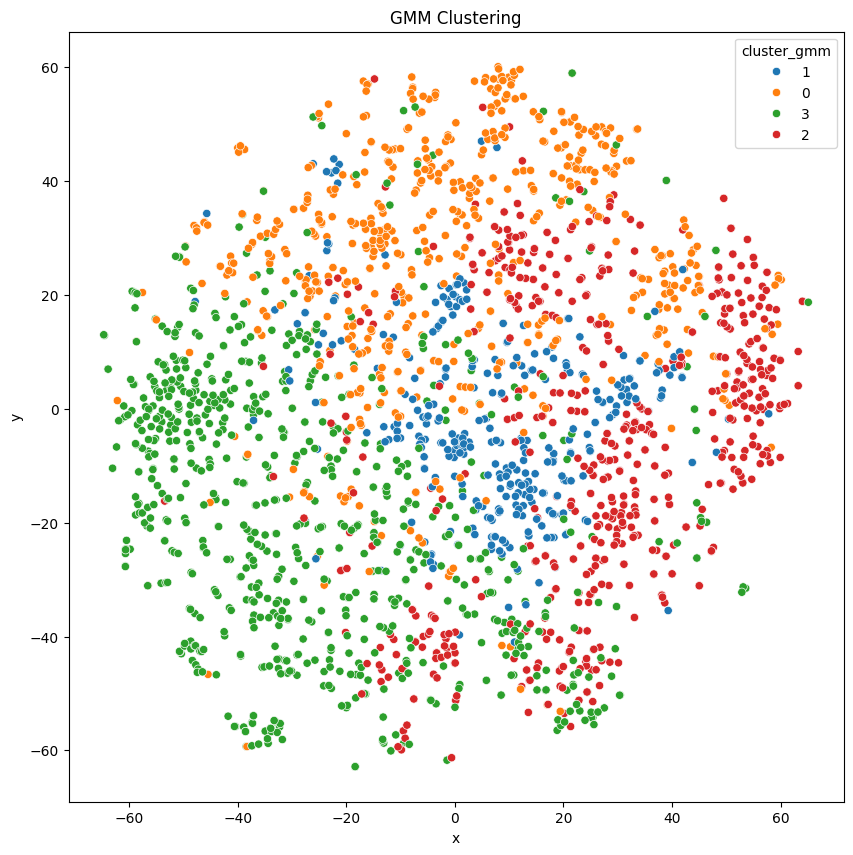

In [55]:
# visualize data

# visutalize the cluster using the t-SNE df

df_tsne['cluster_gmm'] = df['cluster_gmm'].astype(str).values

reverse_cluster_map = {v: k for k, v in cluster_map.items()}

plt.figure(figsize=(10, 10))

plt.title('GMM Clustering')

# make color scheme red, blue, green etc


df_tsne['cluster_gmm'] = df_tsne['cluster_gmm'].map(str)

sns.scatterplot(data=df_tsne, x='x', y='y', hue='cluster_gmm')

plt.show()

## Measurements

In [56]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def evluate_model(real, pred):
    precision = precision_score(real, pred, average='macro')
    recall = recall_score(real, pred, average='macro')
    f1 = f1_score(real, pred, average='macro')
    accuracy = accuracy_score(real, pred)

    return precision, recall, f1, accuracy

In [57]:
kmeans_evalutation_df = pd.DataFrame(columns=['precision', 'recall', 'f1', 'accuracy'])

kmeans_evalutation_df.loc['kmeans'] = evluate_model(df['cluster'], df['cluster_kmeans'])

kmeans_evalutation_df

,precision,recall,f1,accuracy
kmeans,0.190291,0.213727,0.2007,0.218244


In [58]:
# same for DBSCAN but map -1 to 2
df['cluster_dbscan'] = df['cluster_dbscan'].map(lambda x: x if x != -1 else 2)

dbscan_evalutation_df = pd.DataFrame(columns=['precision', 'recall', 'f1', 'accuracy'])

dbscan_evalutation_df.loc['dbscan'] = evluate_model(df['cluster'], df['cluster_dbscan'])

dbscan_evalutation_df

,precision,recall,f1,accuracy
dbscan,0.063832,0.25,0.101698,0.255328


In [59]:
# same for GMM

gmm_evalutation_df = pd.DataFrame(columns=['precision', 'recall', 'f1', 'accuracy'])

gmm_evalutation_df.loc['gmm'] = evluate_model(df['cluster'], df['cluster_gmm'])

gmm_evalutation_df

,precision,recall,f1,accuracy
gmm,0.190291,0.213727,0.2007,0.218244
